In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# LOCAL
PROJECT_PATH = '/Users/ivan_zorin/Documents/DEV/code/ntl/'
DATA_PATH = '/Users/ivan_zorin/Documents/DEV/data/sgcc/data.csv'
LOG_DIR = '/Users/ivan_zorin/Documents/DEV/runs/debug/trainer'

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

import sys
sys.path.append(PROJECT_PATH)

from ntl.data import SGCCDataset
from ntl.data.transforms import FillNA, Scale, Diff, Cutout

In [53]:
transforms = [
    FillNA('drift'), 
    # Cutout(256), 
    Scale('minmax'), 
    # Diff(1)
]

normal_dataset = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)

anomal_dataset = SGCCDataset(DATA_PATH, label=1, nan_ratio=1.0, transforms=transforms, year=2016)

In [65]:
normal_data = normal_dataset.data
for tr in transforms:
    normal_data = tr(normal_data)
    
labels = np.zeros(normal_data.shape[0])
N = normal_data.shape[0]
print(N)


38701


In [66]:
anomal_data = anomal_dataset.data
for tr in transforms:
    anomal_data = tr(anomal_data)

anomal_labels = np.ones(anomal_data.shape[0])
M = anomal_data.shape[0]
print(M)

3580


In [67]:
all_data = np.concatenate([normal_data, anomal_data], axis=0)
all_labels = np.concatenate([labels, anomal_labels], axis=0)
NM = all_data.shape[0]
print(N + M == NM)

True


In [112]:
def decompose(method, data, **kwargs):
    data = method.fit_transform(data)
    return data

### tSNE

In [69]:
tsne = TSNE(2)
all_data_tsne = tsne.fit_transform(all_data)

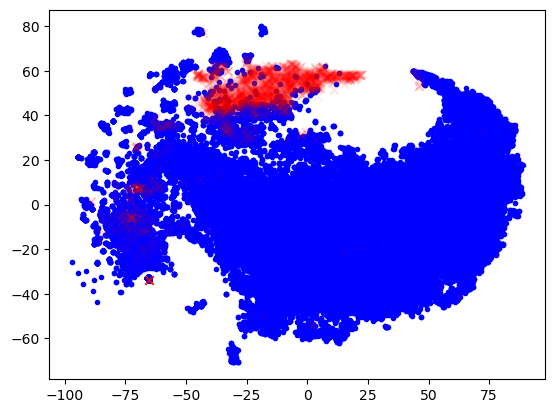

In [99]:
plt.figure()
plt.scatter(all_data_tsne[:N, 0], all_data_tsne[:N, 1], color='b', marker='.')
plt.scatter(all_data_tsne[N:, 0], all_data_tsne[N:, 1], color='r', marker='x', label='anomal', alpha=0.05)

plt.show()

### PCA

In [87]:
pca = PCA(2)
all_data_pca = pca.fit_transform(all_data)

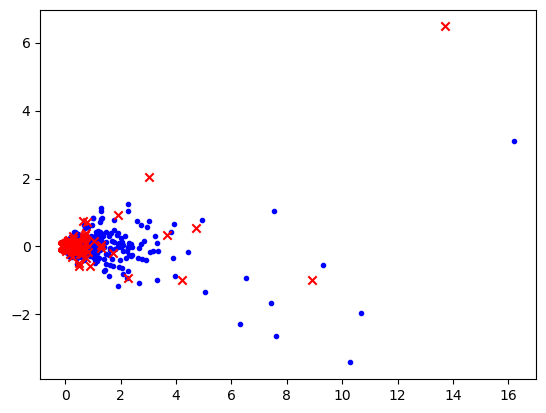

In [91]:
plt.figure()
plt.scatter(all_data_pca[:N, 0], all_data_pca[:N, 1], color='b', marker='.')
plt.scatter(all_data_pca[N:, 0], all_data_pca[N:, 1], color='r', marker='x', label='anomal')

plt.show()

### GaussianMixture

In [104]:
train, test = train_test_split(normal_data, test_size=anomal_data.shape[0])
test = np.concatenate([test, anomal_data])

In [123]:
gmm_data = np.concatenate([train, test])
gmm_data_tsne = TSNE(2).fit_transform(gmm_data)

train_N = train.shape[0]
test_normal_N = test_anomal_N = test.shape[0] // 2

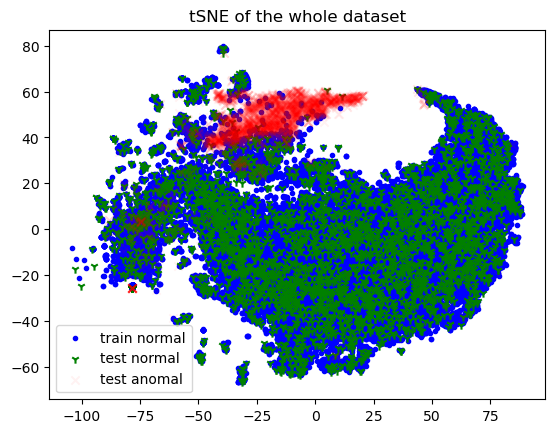

In [181]:
plt.figure()
plt.scatter(gmm_data_tsne[:train_N, 0], gmm_data_tsne[:train_N, 1], color='b', marker='.', label='train normal')
plt.scatter(gmm_data_tsne[train_N:train_N + test_normal_N, 0], gmm_data_tsne[train_N:train_N + test_normal_N, 1], color='g', marker='1', label='test normal')

plt.scatter(gmm_data_tsne[train_N + test_normal_N:, 0], gmm_data_tsne[train_N + test_normal_N:, 1], color='r', marker='x', label='test anomal', alpha=0.05)
plt.legend()
plt.title('tSNE of the whole dataset')
plt.show()

In [149]:
x, y = gmm_data_tsne[:, 0], gmm_data_tsne[:, 1]
labels = np.concatenate([np.zeros(train_N), np.ones(test_normal_N), 2 * np.ones(test_anomal_N)])

colors = ['b'] * train_N + ['g'] * test_normal_N + ['r'] * test_anomal_N
markers = ['.'] * train_N + ['1'] * test_normal_N + ['x'] * test_anomal_N



In [144]:
import seaborn as sns

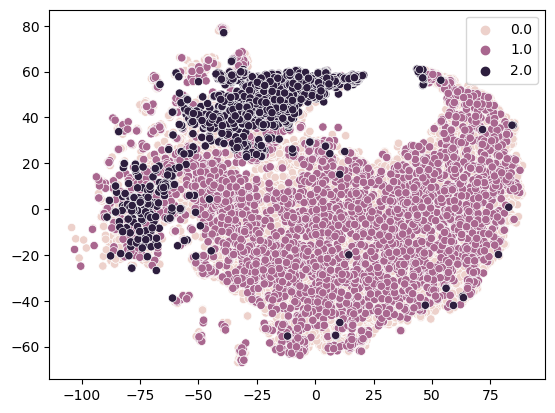

In [154]:
plt.figure()
sns.scatterplot(x=x, y=y, hue=labels, markers=labels)
plt.show()

In [156]:
gmm_kwargs = {
    'n_components': 1,
    'covariance_type': 'full'
}

gmm = GaussianMixture(**gmm_kwargs)

In [157]:
gmm.fit(train)

GaussianMixture()

In [251]:
test_scores = gmm.score_samples(test)

In [252]:
test_labels = np.concatenate([np.zeros(test_normal_N), np.ones(test_anomal_N)])

In [258]:
from sklearn.metrics import roc_curve, roc_auc_score

In [259]:
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
auc = roc_auc_score(test_labels, test_scores)
auc

0.6393846165850005

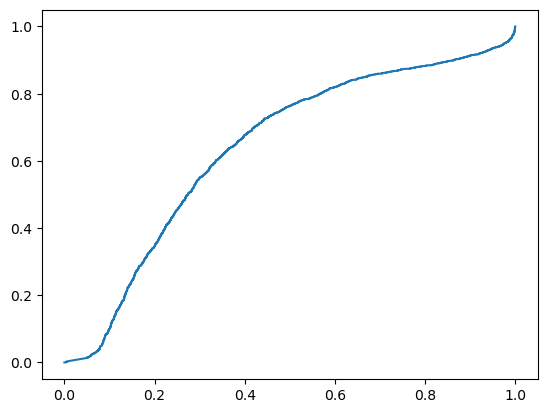

In [256]:
plt.plot(fpr, tpr)

In [242]:
def normal_dist(X, mu, sigma):
    k = X.shape[1]
    scores = np.exp(-0.5 * (X - mu) @ np.linalg.inv(sigma) @ (X - mu).T) / np.sqrt(np.power(2 * np.pi, k) * np.linalg.det(sigma))
    return scores

In [209]:
mu = gmm.means_
sigma = gmm.covariances_.squeeze()

In [243]:
s = normal_dist(test, gmm.means_, gmm.covariances_.squeeze())

/var/folders/2x/mjd644kn7717gdn9wmj101n00000gr/T/ipykernel_30896/2683309771.py:3: RuntimeWarning: overflow encountered in exp
  scores = np.exp(-0.5 * (X - mu) @ np.linalg.inv(sigma) @ (X - mu).T) / np.sqrt(np.power(2 * np.pi, k) * np.linalg.det(sigma))
/var/folders/2x/mjd644kn7717gdn9wmj101n00000gr/T/ipykernel_30896/2683309771.py:3: RuntimeWarning: divide by zero encountered in divide
  scores = np.exp(-0.5 * (X - mu) @ np.linalg.inv(sigma) @ (X - mu).T) / np.sqrt(np.power(2 * np.pi, k) * np.linalg.det(sigma))
/var/folders/2x/mjd644kn7717gdn9wmj101n00000gr/T/ipykernel_30896/2683309771.py:3: RuntimeWarning: invalid value encountered in divide
  scores = np.exp(-0.5 * (X - mu) @ np.linalg.inv(sigma) @ (X - mu).T) / np.sqrt(np.power(2 * np.pi, k) * np.linalg.det(sigma))
